# Rayleigh-normal distribution functions

## Step 1: Definitions

The continuous fidelity (or the Bhattacharyya coefficient) for continuous probability distributions $p$ and $q$ on $\mathbb{R}$ is defined by (https://arxiv.org/pdf/1306.4166.pdf):
\begin{align}
\mathcal{F}(p, q) := \int_{\mathbb{R}} \sqrt{p(x) q(x)} dx
\end{align}

For any $\mu \in \mathbb{R}$ and $\nu > 0$, let $\Phi_{\mu, \nu}$ and $\phi_{\mu, \nu}$ denote the cdf and pdf of the Gaussian distribution of mean $\mu$ and variance $\nu$.  In particular, we denote $\Phi$ and $\phi$ as the cdf and pdf the standard normal distribution.

### Definition 1

The Rayleigh-normal distribution function $Z_\nu$ on $\mathbb{R}$ is defined by:
\begin{align}
Z_\nu := \begin{cases}
1 - \sup_A \mathcal{F}\left(\frac{dA}{dx}, \phi_{\mu, \nu}\right)^2, & \nu > 0 \\
\Phi, & \nu = 0
\end{cases}
\end{align}
where $A : \mathbb{R} \to [0, 1]$ runs over continuously differentiable monotone increasing functions satisfying $\Phi \leq A \leq 1$ on the right hand side.

It can be shown that:
1. The Rayleigh-normal distribution function $Z_\nu$ can be shown to be right-continuous at $\nu = 0$.

We denote the cdf of the Rayleigh distribution with scale parameter $\sigma > 0$ by:
\begin{align}
    R_{\sigma}(x) = \begin{cases}
    1 - e^{- \frac{x^2}{2 \sigma^2}}, & x > 0 \\
    0, & x \leq 0
    \end{cases}.
\end{align}

### Lemma 2

When $0 < \nu < 1$, the equation with respect to $x$
\begin{align}
    \frac{\phi(x)}{\phi_{\mu, \nu}(x)} = \frac{1 - \Phi(x)}{1 - \Phi_{\mu, \nu}(x)}
\end{align}
has a unique solution $\beta_{\mu, \nu}$.

It can be shown that:
1. $\beta_{\mu, \nu} < \frac{\mu}{1 - \nu}$
1. $\beta_{\mu, \nu}$ is differentiable and monotonically increasing with respect to $\mu$

### Lemma 3

When $\nu > 1$, the equation with respect to $x$
\begin{align}
    \frac{\phi(x)}{\phi_{\mu, \nu}(x)} = \frac{\Phi(x)}{\Phi_{\mu, \nu}(x)}
\end{align}
has a unique solution $\alpha_{\mu, \nu}$.

It can be shown that:
1. $\alpha_{\mu, \nu} > \frac{\mu}{1 - \nu}$
1. $\alpha_{\mu, \nu}$ is differentiable and monotonically decreasing with respect to $\mu$

### Theorem 7 (Explicit form of $Z_\nu$)

For $\nu \geq 0$, we have:
\begin{align}
    Z_\nu(\mu)
    = \begin{cases}
    \Phi(\mu), & \nu = 0 \\
    1 - (\sqrt{1 - \Phi(\beta_{\mu, \nu})} \sqrt{1 - \Phi_{\mu, \nu}(\beta_{\mu, \nu})} + I_{\mu, \nu}(\beta_{\mu, \nu}))^2, & 0 < \nu < 1 \\
    R_{\sqrt{2}}(\mu), & \nu = 1 \\
    1 - (\sqrt{\Phi(\alpha_{\mu, \nu}) \Phi_{\mu, \nu}(\alpha_{\mu, \nu})} + I_{\mu, \nu}(\infty)- I_{\mu, \nu}(\alpha_{\mu, \nu}))^2, & \nu > 1
    \end{cases}
\end{align}

where
\begin{align}
I_{\mu, \nu}(x) := \sqrt{\frac{2 \sqrt{\nu}}{1 + \nu}} e^{- \frac{\mu^2}{4(1 + \nu)}} \Phi_{\frac{\mu}{1 + \nu}, \frac{2\nu}{1 + \nu}}(x)
\end{align}
and
\begin{align}
I_{\mu, \nu}(\infty) := \sqrt{\frac{2 \sqrt{\nu}}{1 + \nu}} e^{- \frac{\mu^2}{4(1 + \nu)}}.
\end{align}

## Step 2: Calculations

### Import modules

In [1]:
from scipy.stats import norm, rayleigh, rv_continuous
from scipy.optimize import fsolve, root, minimize
from math import sqrt, exp, log
import numpy as np
import matplotlib.pyplot as plt
import os

FIG_HOME = 'fig'
def savefig(filename, *args, **kwargs):
    path = os.path.join(FIG_HOME, filename)
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(path, *args, **kwargs)

### Define functions

1. $\alpha, \beta$

In [2]:
def equation(x, mean, var, mode):
    sd = sqrt(var)
    if mode == 'alpha':
        return -log(1e-5 + norm.pdf(x) * norm.cdf(x, mean, sd)) + log(1e-5 + norm.pdf(x, mean, sd) * norm.cdf(x))
    else:
        # mode == 'beta'
        return -log(1e-5 + norm.pdf(x) * norm.sf(x, mean, sd)) + log(1e-5 + norm.pdf(x, mean, sd) * norm.sf(x))
    
# For numerical stability
def jac(x, mean, var, mode):
    sd = sqrt(var)
    if mode == 'alpha':
        return - x * norm.pdf(x) * norm.cdf(x, mean, sd) + \
            norm.cdf(x) * norm.pdf(x, mean, sd) * (x - mean) / var
    else:
        # mode == 'beta'
        return - x * norm.pdf(x) * norm.sf(x, mean, sd) + norm.sf(x) * norm.pdf(x, mean, sd) * (x - mean) / var
    
def solve(mean, var, mode):
    if mode == 'alpha':
        initial_guess = mean / (1 - var) + 0.5 if abs(mean) < 4 else mean / (1 - var)
    else:
        # mode == 'beta'
        initial_guess = mean / (1 - var) - 0.5 if abs(mean) < 4 else mean / (1 - var)
    result = root(equation, initial_guess, (mean, var, mode), tol=1e-20, options={'factor':0.11}).x
    return result

# Assumes var > 1
def alpha(mean, var):
    if var <= 1:
        raise ValueError("Requires: var > 1")
    return solve(mean, var, 'alpha')

# Assumes 0 < var < 1
def beta(mean, var):
    if var <= 0 or var >= 1:
        raise ValueError("Requires: 0 < var < 1")
    return solve(mean, var, 'beta')

2. $I_{\mu, \nu}(x)$

In [3]:
def I(x, mean, var):
    sd = sqrt(var)
    head = sqrt(2 * sd / (1 + var))
    exponent = - mean**2 / (4 * (1 + var))
    coeff = head * exp(exponent)
    
    if x == 'inf':
        return coeff
    else:
        return coeff * norm.cdf(x, loc=mean / (1 + var), scale=sqrt(2 * var / (1 + var)))

3. $Z_{\nu}(\mu)$

In [4]:
def Z(mean, var):
    if var < 0:
        raise ValueError("Requires: var >= 0")
        
    if var == 0:
        return norm.cdf(mean)
    elif var > 0 and var < 1:
        b = beta(mean, var)
        sd = sqrt(var)
        return 1 - (sqrt(norm.sf(b)) * sqrt(norm.sf(b, mean, sd)) + I(b, mean, var))**2
    elif var == 1:
        return rayleigh.cdf(mean, scale=sqrt(2))
    else:
        # var > 1
        '''
        a = alpha(mean, var)
        sd = sqrt(var)
        return 1 - (sqrt(norm.cdf(a)) * sqrt(norm.cdf(a, mean, sd)) + I('inf', mean, var) - I(a, mean, var))**2
        '''
        return Z(mean / sqrt(var), 1 / var)

### Define a new distrbution object

In [5]:
class rayleigh_norm(rv_continuous):
    '''Rayleigh-normal distribution'''
    def _cdf(self, x, var):
        return Z(x, var)
    
    def _argcheck(self, *args):
        """Default check for correct values on args and keywords.
        Returns condition array of 1's where arguments are correct and
         0's where they are not.
        """
        cond = 1
        for arg in args:
            cond = np.logical_and(cond, (np.asarray(arg) > -np.inf))
        return cond

### Testing and plotting

In [6]:
rn = rayleigh_norm()
print('Inverse cdf:')
print('1st percentile of order-0 Rayleigh-normal: {:.3f}'.format(rn.ppf(0.01, var=0.0)))
print('99th percentile of order-0 Rayleigh-normal: {:.3f}'.format(rn.ppf(0.99, var=0.0)))
print('1st percentile of order-1 Rayleigh-normal: {:.3f}'.format(rn.ppf(0.01, var=1.0)))
print('99th percentile of order-1 Rayleigh-normal: {:.3f}'.format(rn.ppf(0.99, var=1.0)))

Inverse cdf:
1st percentile of order-0 Rayleigh-normal: -2.326
99th percentile of order-0 Rayleigh-normal: 2.326
1st percentile of order-1 Rayleigh-normal: 0.201
99th percentile of order-1 Rayleigh-normal: 4.292


/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


Text(0.5, 1.0, '$\\alpha_{\\mu, 1.5}$ and $\\beta_{\\mu, 0.5}$')

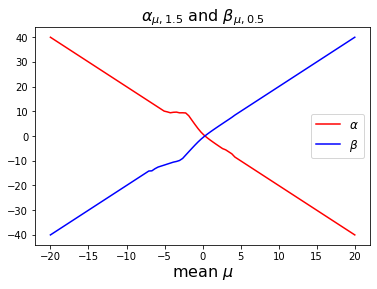

In [7]:
xs = np.linspace(-20, 20, 100)
alphas = np.array([alpha(mean=x, var=1.5) for x in xs])
betas = np.array([beta(mean=x, var=0.5) for x in xs])

fig, ax = plt.subplots(1, 1)
alpha_line = ax.plot(xs, alphas, 'r-')
beta_line = ax.plot(xs, betas, 'b-')
ax.legend([alpha_line, beta_line], labels=[r'$\alpha$', r'$\beta$'], fontsize=12)
ax.set_xlabel(r'mean $\mu$', fontsize=16)
ax.set_title(r'$\alpha_{\mu, 1.5}$ and $\beta_{\mu, 0.5}$', fontsize=16)

## Step 3: Plots of the Rayleigh-normal distribution function

### Import modules

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import pdb

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; ret

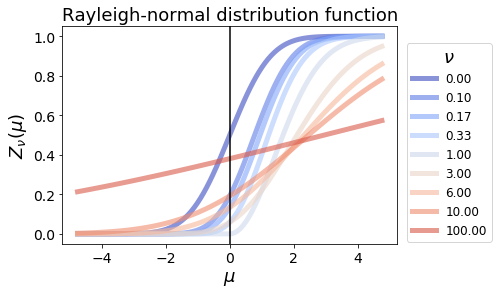

In [62]:
fig, ax = plt.subplots(1, 1)

np.random.seed(205)

vars = [0, 1/10, 1/6, 1/3, 1, 3, 6, 10, 100]
x = np.linspace(rn.ppf(0.000001, 0), rn.ppf(0.999999, 0), 100)
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(vars))))

lines = []
for var in vars:
    cdf = np.array([rn.cdf(x_index, var) for x_index in x])
    line = ax.plot(x, cdf, '-', lw=5, alpha=0.6, label='var = {}'.format(var))
    lines.append(line)

lgd = ax.legend(lines, labels=['{:.2f}'.format(var) for var in vars], fontsize=12, \
          loc='upper right', bbox_to_anchor=(1.3, 0.95), title=r'$\nu$', title_fontsize=18)
ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_ylabel(r'$Z_\nu(\mu)$', fontsize=18)
ax.axvline(x=0, color='black')
ax.set_title('Rayleigh-normal distribution function', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
savefig('rayleigh-normal.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Step 4: Optimizing lower-bound and upper-bound functions with constrained minimization

### Import modules

In [8]:
from scipy.optimize import minimize

### Define constrained minimization

In [9]:
def sqrt_error_bound(eps, lamb=None):
    return sqrt(eps) if lamb is None else lamb * (1 - sqrt(eps))

def error_bound(eps, lamb=None):
    return eps if lamb is None else lamb * (1 - eps)

def min_objective(err_1, var, eps, lamb=None, metric='original', bound='upper'):
    if metric == 'original':
        err_2 = (sqrt_error_bound(eps, lamb) - sqrt(err_1))**2
        result = -(norm.ppf(err_1) + sqrt(var) * norm.ppf(err_2))
    elif metric == 'purified':
        err_2 = error_bound(eps, lamb) - err_1
        result = -(norm.ppf(err_1**2) + sqrt(var) * norm.ppf(err_2**2)) if bound == 'upper' \
                    else -(norm.ppf(err_1**2) + sqrt(var) * norm.ppf(err_2**2)) # lower bound
    return result

def jac(err_1, var, eps, lamb=None, metric='original', bound='upper'):
    if metric == 'original':
        err_2 = (sqrt_error_bound(eps, lamb) - sqrt(err_1))**2
        result = -(1 / (norm.pdf(norm.ppf(err_1))) - sqrt(var) * sqrt(err_2 / err_1) / (norm.pdf(norm.ppf(err_2))))
    elif metric == 'purified':
        err_2 = error_bound(eps, lamb) - err_1
        result = -(2 * err_1 / (norm.pdf(norm.ppf(err_1**2))) - sqrt(var) * (2 * err_2) / (norm.pdf(norm.ppf(err_2**2)))) \
                    if bound == 'upper' else \
                 -((2 * err_1) / (norm.pdf(norm.ppf(err_1**2))) - sqrt(var) * (2 * err_2) / (norm.pdf(norm.ppf(err_2**2)))) # lower bound
    return result

def guess(eps, lamb=None, metric='original', bound='upper'):
    return (sqrt_error_bound(eps, lamb) / 2)**2/4 if metric == 'original' else error_bound(eps, lamb) / 2

def bound_on_opt_variable(eps, lamb=None, metric='original'):
    return sqrt_error_bound(eps, lamb)**2 if metric == 'original' else error_bound(eps, lamb)

In [10]:
def maximize_lower(var, eps, lamb=None, verbose=False, metric='original', bound='lower', method='SLSQP'):
    initial_guess = guess(eps, lamb, metric, bound)
    bound_on_err = bound_on_opt_variable(eps, metric=metric)
    
    err_1 = minimize(min_objective, initial_guess, (var, eps, lamb, metric, bound), jac=jac, \
                     bounds=((0, bound_on_err),), tol=1e-10, method=method).x[0]
    bound = -min_objective(err_1, var, eps, metric=metric)
    if verbose:
        print('lower bound maximized at: eps_1 = {:.3f}; with value = {:.3f}'.format(err_1, bound))
    return bound

def minimize_upper(var, eps, lamb, verbose=False, metric='original', bound='upper', method='SLSQP'):
    initial_guess = guess(eps, lamb, metric, bound)
    bound_on_err = bound_on_opt_variable(eps, lamb, metric=metric)
    
    err_1 = minimize(min_objective, initial_guess, (var, eps, lamb, metric, bound), jac=jac, \
                     bounds=((0, bound_on_err),), tol=1e-10, method=method).x[0]
    bound = min_objective(err_1, var, eps, lamb, metric=metric)
    if verbose:
        print('upper bound minimized at: eta_1 = {:.3f}; with value = {:.3f}'.format(err_1, bound))
    return bound

### Testing and plotting

In [11]:
var = 0.0
eps = 0.25
lamb = 0.999
method = 'SLSQP'
metric = 'original'

maximize_lower(var, eps, verbose=True, metric=metric, method=method)
minimize_upper(var, eps, lamb, verbose=True, metric=metric, method=method)
print('target value = {:.3f}'.format(rn.ppf(eps, var)))

lower bound maximized at: eps_1 = 0.250; with value = -0.674
upper bound minimized at: eta_1 = 0.250; with value = 0.676
target value = -0.674


In [12]:
def plot_helper(plot_inverse_cdf):
        return lambda x: x if plot_inverse_cdf else lambda x: rn.cdf(x)

def plot_against_var(eps_s, lamb, var_min, var_max, num_points, metric='original', plot_inverse_cdf=True):
    transform = plot_helper(plot_inverse_cdf)
    
    for eps in eps_s:
        var_s = np.linspace(var_min, var_max, num_points)
        uppers = np.array([transform(minimize_upper(var, eps, lamb, metric=metric)) for var in var_s])
        targets = np.array([transform(rn.ppf(eps, var)) for var in var_s])
        lowers = np.array([transform(maximize_lower(var, eps, metric=metric)) for var in var_s])

        fig, ax = plt.subplots(1, 1)
        upper_curve = ax.plot(var_s, uppers, 'b-', lw=5, alpha=0.6, label='upper bound')
        target_curve = ax.plot(var_s, targets, 'g-', lw=5, alpha=0.6, label='target')
        lower_curve = ax.plot(var_s, lowers, 'r-', lw=5, alpha=0.6, label='lower bound')

        lines = [upper_curve, target_curve, lower_curve]
        target_string = r'$Z_\nu^{-1}(\varepsilon)$' if plot_inverse_cdf else r'$\varepsilon$'
        lgd = ax.legend(lines, labels=['upper bound', r'target value = ' + target_string, 'lower bound'], fontsize=16, \
                        loc='upper right', bbox_to_anchor=(1.75, 0.75))
        plt.xlabel(r'$\nu$', fontsize=16)
        plt.ylabel(r'$\frac{D(\tau \|| \omega)}{\sqrt{V(\rho \|| \sigma)}} \sqrt{n} \left(R - \frac{D(\rho \|| \sigma)}{D(\tau \|| \omega)}\right)$', fontsize=16)
        plt.title(r'Target and bounds: $\varepsilon$ = {:.2f}'.format(eps), fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        savefig(os.path.join('rate-to-var', metric, 'eps={:.2f}.pdf'.format(eps)), bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

In [13]:
def plot_against_eps(var_s, lamb, eps_min, eps_max, num_points, metric='original', plot_inverse_cdf=True):
    transform = plot_helper(plot_inverse_cdf)
    
    for var in var_s:
        eps_s = np.linspace(eps_min, eps_max, num_points)
        uppers = np.array([transform(minimize_upper(var, eps, lamb)) for eps in eps_s])
        targets = np.array([transform(rn.ppf(eps, var)) for eps in eps_s])
        lowers = np.array([transform(maximize_lower(var, eps)) for eps in eps_s])

        fig, ax = plt.subplots(1, 1)
        upper_curve = ax.plot(eps_s, uppers, 'b-', lw=5, alpha=0.6, label='upper bound')
        target_curve = ax.plot(eps_s, targets, 'g-', lw=5, alpha=0.6, label='target')
        lower_curve = ax.plot(eps_s, lowers, 'r-', lw=5, alpha=0.6, label='lower bound')

        lines = [upper_curve, target_curve, lower_curve]
        target_string = r'$Z_\nu^{-1}(\varepsilon)$' if plot_inverse_cdf else r'$\varepsilon$'
        lgd = ax.legend(lines, labels=['upper bound', r'target value = ' + target_string, 'lower bound'], fontsize=16, \
                        loc='upper right', bbox_to_anchor=(1.75, 0.75))
        plt.xlabel(r'$\varepsilon$', fontsize=16)
        plt.ylabel(r'$\frac{D(\tau \|| \omega)}{\sqrt{V(\rho \|| \sigma)}} \sqrt{n} \left(R - \frac{D(\rho \|| \sigma)}{D(\tau \|| \omega)}\right)$', fontsize=16)
        plt.title(r'Target and bounds: $\nu$ = {:.2f}'.format(var), fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        savefig(os.path.join('rate-to-eps', metric, 'var={:.2f}.pdf'.format(var)), bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

In [81]:
lamb = 0.99
num_points = 50
var_min = 0.0
var_max = 5.0
eps_min = 0.0
eps_max = 1.0
eps_s = [0.01, 0.25, 0.5, 0.75, 0.99]
var_s = [0.0, 0.25, 0.5, 0.75, 1.0, 2.0, 10.0, 100.0]
metric = 'original'

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


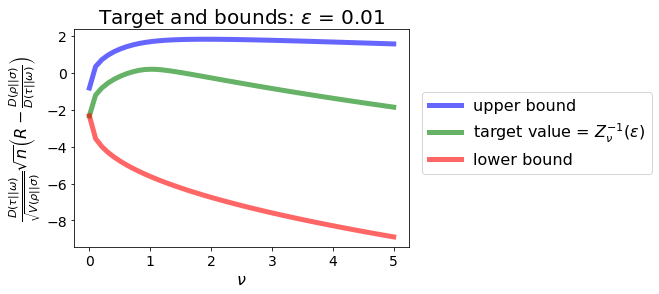

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


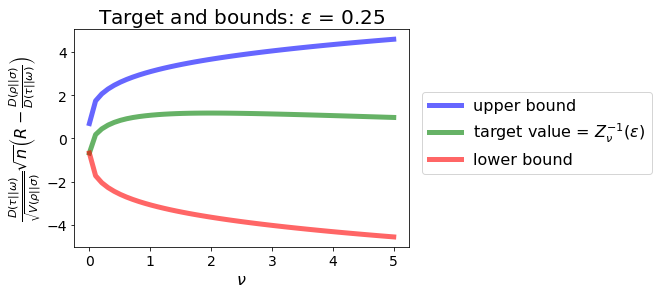

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


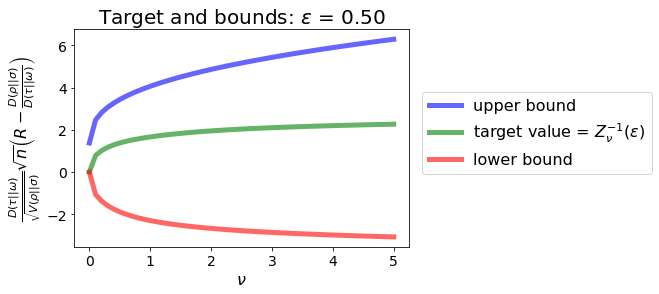

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


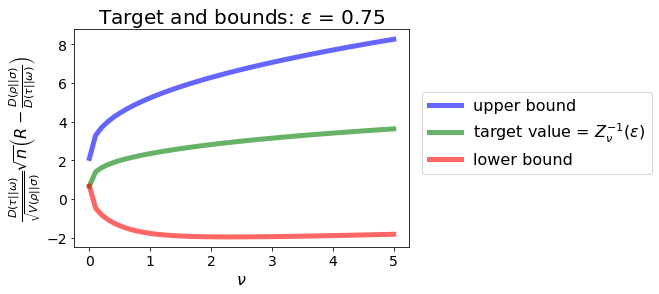

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


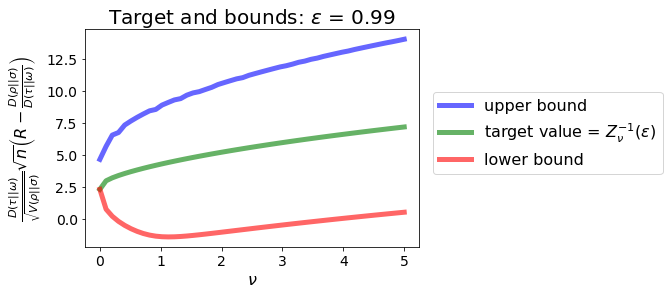

In [83]:
plot_against_var(eps_s, lamb, var_min, var_max, num_points, metric)

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


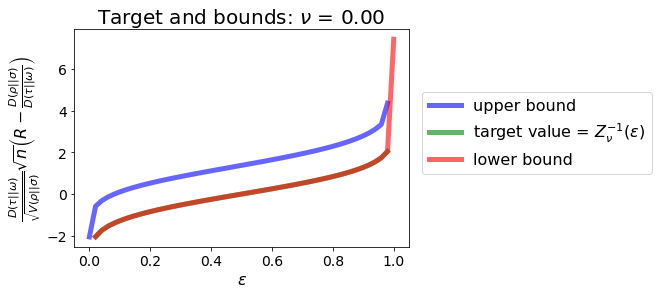

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


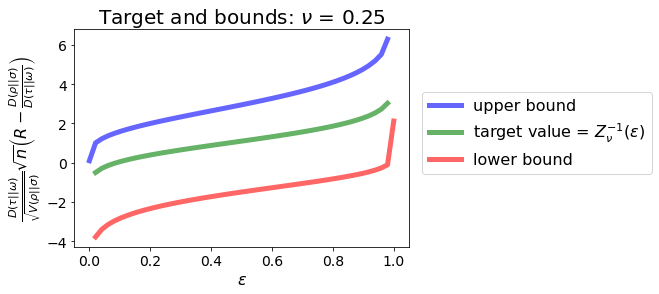

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


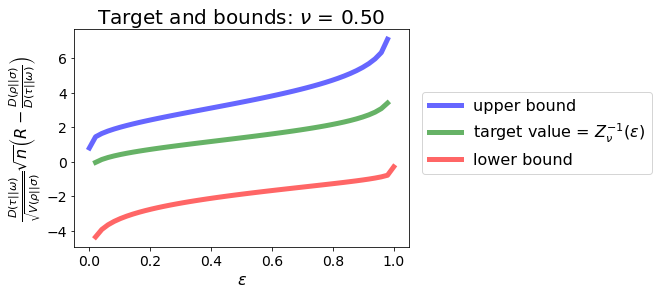

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


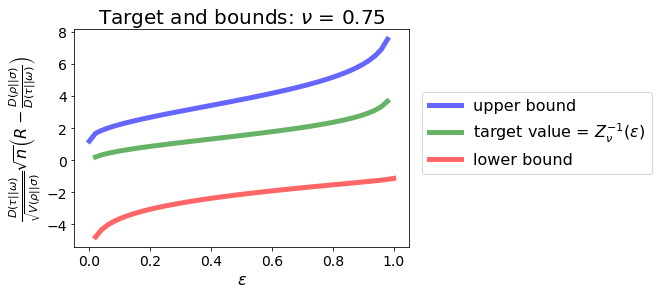

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


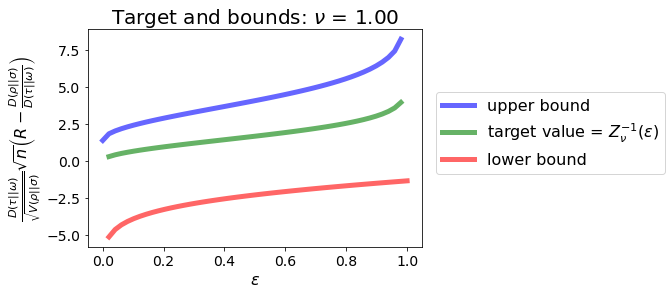

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


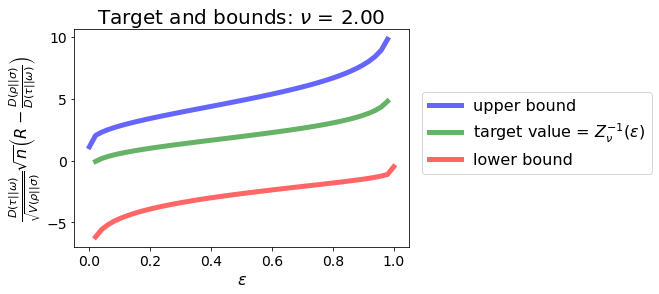

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


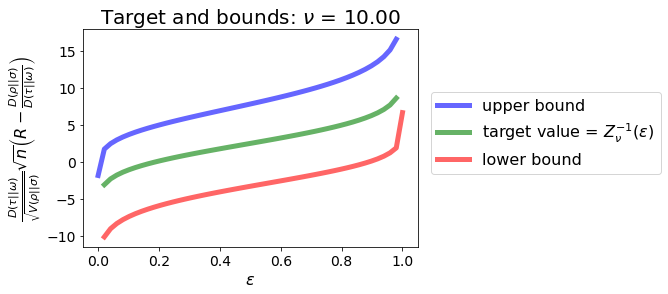

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


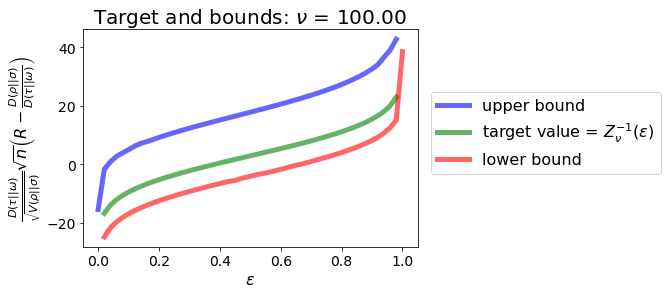

In [82]:
plot_against_eps(var_s, lamb, eps_min, eps_max, num_points, metric)

## Step 5: Optimizing lower-bound and upper-bound functions via Solvers

### Define helper functions

In [15]:
def minimizer_helper(err):
    return norm.ppf(max(0, min(1, err)))**2 + log(err)

# Does not use eps
def minimizer(err_1, err_2, var):
    return minimizer_helper(err_1) - minimizer_helper(err_2) - var

# Does not use var
def feasibility(err_1, err_2, sqrt_error_bound):
    return sqrt_error_bound - sqrt(err_1) - sqrt(err_2)

def sqrt_error_bound(eps, lamb=None):
    return sqrt(eps) if lamb is None else lamb * (1 - sqrt(eps))

def initial_guesses(eps, lamb=None):
    initial_guess = (sqrt_error_bound(eps, lamb) / 2)**2
    return (initial_guess+1e-2, initial_guess-1e-2)

def test(minimizer_result, feasibility_result, error_tol):
    assert max(abs(minimizer_result), abs(feasibility_result)) < error_tol, \
        "Error in minimizer: {}; Error in feasibility constraint: {}".format(abs(minimizer_result), \
                                                                             abs(feasibility_result))
    print('Solver test: Pass!')

### Lower-bound function $\ell(\varepsilon_1; \nu, \varepsilon)$

In [16]:
def lower_bound_equations(eps_12, var, eps):
    eps_1, eps_2 = eps_12
    return (minimizer(eps_1, eps_2, var), feasibility(eps_1, eps_2, sqrt_error_bound(eps)))

def lower_bound_solver(var, eps):
    return fsolve(lower_bound_equations, initial_guesses(eps), (var, eps), factor=0.11) # (eps_1, eps_2)

def verify_lower_bound_solver(var, eps, error_tol=1e-8):
    eps_1, eps_2 = lower_bound_solver(var, eps)
    minimizer_result, feasibility_result = lower_bound_equations((eps_1, eps_2), var, eps)
    test(minimizer_result, feasibility_result, error_tol)
    
def lower_bound(var, eps):
    eps_1, eps_2 = lower_bound_solver(var, eps)
    return norm.ppf(eps_1) + sqrt(var) * norm.ppf(eps_2)

### Upper-bound function $u(\eta_1, \lambda; \nu, \varepsilon)$

In [17]:
def upper_bound_equations(eta_12, var, eps, lamb):
    eta_1, eta_2 = eta_12
    return (minimizer(eta_1, eta_2, var), feasibility(eta_1, eta_2, sqrt_error_bound(eps, lamb)))

def upper_bound_solver(var, eps, lamb):
    return fsolve(upper_bound_equations, initial_guesses(eps, lamb), (var, eps, lamb), factor=0.11) # (eta_1, eta_2)

def verify_upper_bound_solver(var, eps, lamb, error_tol=1e-8):
    eta_1, eta_2 = upper_bound_solver(var, eps, lamb)
    minimizer_result, feasibility_result = upper_bound_equations((eta_1, eta_2), var, eps, lamb)
    test(minimizer_result, feasibility_result, error_tol)
    
def upper_bound(var, eps, lamb):
    eta_1, eta_2 = upper_bound_solver(var, eps, lamb)
    return norm.ppf(1 - eta_1) + sqrt(var) * norm.ppf(1 - eta_2)

### Testing and plotting

#### Define plotting functions

In [77]:
def bound_function(err_1, eps, var, lamb=None):
    err_2 = (sqrt_error_bound(eps, lamb) - sqrt(err_1))**2
    multiplier = 1.0 if lamb is None else -1.0
    return multiplier * (norm.ppf(err_1) + sqrt(var) * norm.ppf(err_2))

def plot_bound_function(num_points, eps, var, lamb=None):
    upper_bound = sqrt_error_bound(eps, lamb)**2
    xs = np.linspace(0+1e-2, eps-1e-2, num_points)
    upper = np.array([bound_function(x, eps, var, lamb) for x in xs if x < upper_bound] + \
                    [rn.ppf(eps, var) for x in xs if x >= upper_bound])
    lower = np.array([bound_function(x, eps, var) for x in xs])
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    upper_curve = axs[0].plot(xs, upper, 'b-', lw=5, alpha=0.6, label='upper bound')
    target = axs[0].axhline(y=rn.ppf(eps, var), lw=5, alpha=0.6, color='green', label='theoretical value')
    axs[0].legend([upper_curve, target], labels=['upper bound', r'target value = $Z_\nu^{-1}(\varepsilon)$'], \
                  loc='upper right', bbox_to_anchor=(1, 0.6), fontsize=12)
    
    upper_min, eps_1_min = min(zip(upper, xs))
    axs[0].scatter(eps_1_min, upper_min, color='black', s=60, alpha=1)
    axs[0].axhline(y=upper_min, color='black', linestyle='--')
    axs[0].annotate("({:.2f}, {:.2f})".format(eps_1_min, upper_min), (eps_1_min, upper_min), fontsize=12, \
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')
    
    target = axs[1].axhline(y=rn.ppf(eps, var), lw=5, alpha=0.6, color='green', label='theoretical value')
    lower_curve = axs[1].plot(xs, lower, 'r-', lw=5, alpha=0.6, label='lower bound')
    axs[1].legend([target, lower_curve], labels=[r'target value = $Z_\nu^{-1}(\varepsilon)$', 'lower bound'], \
                  loc='upper right', bbox_to_anchor=(1, 0.6), fontsize=12)
    
    lower_max, eta_1_max = max(zip(lower, xs))
    axs[1].scatter(eta_1_max, lower_max, color='black', s=60, alpha=1)
    axs[1].axhline(y=lower_max, color='black', linestyle='--')
    axs[1].annotate("({:.2f}, {:.2f})".format(eta_1_max, lower_max), (eta_1_max, lower_max), fontsize=12, \
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')
    
    axs[0].set_xlabel(r'$\eta_1$', fontsize=16)
    axs[1].set_xlabel(r'$\varepsilon_1$', fontsize=16)
    axs[0].set_title(r'Upper bound and target: $\nu$ = {:.2f}; $\varepsilon$ = {:.2f}'.format(var, eps))
    axs[1].set_title(r'Lower bound and target: $\nu$ = {:.2f}; $\varepsilon$ = {:.2f}'.format(var, eps))
    
    savefig(os.path.join('optimizing', 'var={:.2f};eps={:.2f}.pdf'.format(var, eps)))

#### Set hyperparameters

In [78]:
var = 0.5
eps = 0.25
lamb = 0.99
num_points = 100

#### Verify solvers

In [79]:
verify_lower_bound_solver(var, eps)
verify_upper_bound_solver(var, eps, lamb)

Solver test: Pass!
Solver test: Pass!


#### Plot upper and lower bound functions

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


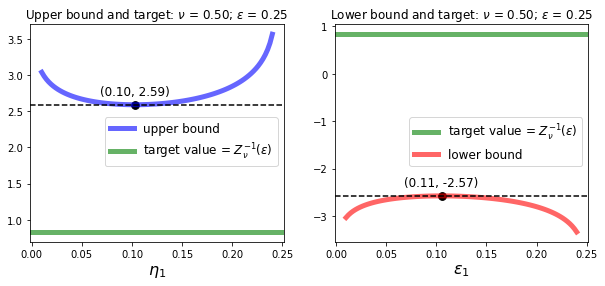

In [80]:
plot_bound_function(num_points, eps, var, lamb)